# CLT - Stage 4

- **Authors:** Arian Contessotto, Tim Giger, Levin Reichmuth
- **Date of Submission:** 1st June 2023

## Content
1. [Load Data](##1.-Load-Data)
2. [Build Embeddings](##2.-Build-Embeddings)
3. [SDG Alignment of DAX Companies](##3.-SDG-Alignment-of-DAX-Companies)
4. [SDG Alignment by Industry: Financial Sector](##4.-SDG-Alignment-by-Industry:-Financial-Sector)
4. [SDG Relevance and Differences by Industries](##5.-SDG-Alignment-by-Industries)

In this notebook, the technique of sentence embeddings is applied to analyse the SDG alignment of German DAX companies, as reflected by communications by/about these companies. Furthermore, differences between internal and external perception are pointed not only for each company but also on industry level.

In [3]:
# Set connection to google drive
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [4]:
# Required package installation
!pip install sentence_transformers
!pip install torch
!pip install kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.2 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=d3a2102e8df5b3f9e1dce7c9c3ec5b710e2906c4cdc7630e1684824c4705b1bb
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.o

In [5]:
# Importa packages
import pandas as pd
import numpy as np
import sentence_transformers
import torch
import plotly.graph_objects as go
import plotly.io as pio
import kaleido
from IPython.display import Image

##1. Load Data

In this stage, the data is loaded. The two datasets are the ESG documents and the SDG descriptions. Afterwards, texts are formed by concatenating different columns. Finally, the unique companies are assigned to a list. The text forming and company storing are necessary preprocessing step for sentence embedding. 

In [6]:
# Define file name
# esg_file = '/content/drive/MyDrive/Colab_Notebooks/CLT_Project_HSLU_Stage2/esg_documents_for_dax_companies_final_stage2.csv'

#Import Levin
esg_file  = '/content/drive/MyDrive/Colab_Notebooks_FS23/CLT/Stage_4/esg_documents_for_dax_companies_final_stage2.csv'

# Define function to load and merge data
def load_esg_data(file):

     # Load the data
     df = pd.read_csv(file, delimiter = '|')

     # Drop unnecessary columns
     df.drop(['word_tokens', 'word_tokens_without_stopwords', 'lemmatization', 'stemming',
              'word_tokens_without_stopwords_text', 'content_for_word_tokens'], axis=1, inplace=True)

     # Apply eval function to columns esg_topics
     df['esg_topics'] = df['esg_topics'].apply(eval)

     return df

# Load and merge the data
esg_documents_df = load_esg_data(esg_file)

# Print shape and diyplay header
print(esg_documents_df.shape)
esg_documents_df.head()

(10469, 16)


,Unnamed: 0,symbol,company,industry,date,title,content,datatype,internal,esg_topics,content_processed,sentence_tokens,length,polarity,sentence_tokens_sentiment,avg_sentiment
0,6187,ADS,Adidas AG,Konsumgüter,2022-05-05,HanesBrands Names Vanessa LeFebvre President o...,"HanesBrands ( NYSE: HBI), a global leader in i...",business,0,"[Transparency, Privacy]","hanesbrands ( nyse: hbi), a global leader in i...","['hanesbrands ( nyse: hbi), a global leader in...",668,0.396053,"[{'sentence': 'hanesbrands ( nyse: hbi), a glo...",0.852941
1,6132,ADS,Adidas AG,Konsumgüter,2021-12-09,adidas x IVY PARK “ HALLS of IVY ” Campaign St...,"adidas x IVY PARK’ s latest drop, “ HALLS of I...",general,0,[Privacy],"adidas x ivy park' s latest drop, "" halls of i...","['adidas x ivy park\' s latest drop, "" halls o...",764,0.276100,[{'sentence': 'adidas x ivy park\' s latest dr...,0.825581
2,6131,ADS,Adidas AG,Konsumgüter,2022-02-24,BLACKPINK’ s Jennie Wore the Coziest $ 52 Tank...,All products featured on Teen Vogue are indepe...,general,0,[Privacy],all products featured on teen vogue are indepe...,['all products featured on teen vogue are inde...,407,0.229783,[{'sentence': 'all products featured on teen v...,0.416667
3,6130,ADS,Adidas AG,Konsumgüter,2021-09-21,Black-History Archives - Page 2 of 6,"Dapper Dan, the iconic Harlem designer who dre...",general,0,"[LGBTQ, HumanRights, GenderDiversity]","dapper dan, the iconic harlem designer who dre...","['dapper dan, the iconic harlem designer who d...",586,0.150078,"[{'sentence': 'dapper dan, the iconic harlem d...",0.666667
4,6129,ADS,Adidas AG,Konsumgüter,2021-09-13,Inclusion Archives - Page 4 of 16,As statues of historical figures such as Chris...,general,0,"[HumanCapital, Diversity, Racism, Misinformation]",as statues of historical figures such as chris...,['as statues of historical figures such as chr...,530,0.240115,[{'sentence': 'as statues of historical figure...,0.615385


In [7]:
# Form esg_texts by concatenating title and content
esg_texts = esg_documents_df.apply(lambda row: " ".join([str(row["title"]), str(row["content"])]), axis=1)
esg_texts[0][:100]

'HanesBrands Names Vanessa LeFebvre President of Global Activewear HanesBrands ( NYSE: HBI), a global'

In [8]:
# Load SDG descriptions
# sdg_df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/CLT_Project_HSLU_Stage3/sdg_descriptions_with_targetsText.csv")

sdg_df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks_FS23/CLT/Stage_4/sdg_descriptions_with_targetsText.csv')

sdg_df.head()

,id,name,description,targets,targets_json_array,progress
0,1,No Poverty,End poverty in all its forms everywhere,"['1.1', 'By 2030, eradicate extreme poverty fo...","[{""target"":""1.1"",""description"":""By 2030, eradi...",['The impact of the COVID-19 pandemic reversed...
1,2,Zero Hunger,"End hunger, achieve food security and improved...","['2.1', 'By 2030, end hunger and ensure access...","[{""target"":""2.1"",""description"":""By 2030, end h...","['Between 2014 and the onset of the pandemic, ..."
2,3,Good Health and Well-being,Ensure healthy lives and promote well-being fo...,"['3.1', 'By 2030, reduce the global maternal m...","[{""target"":""3.1"",""description"":""By 2030, reduc...","['By April 2022, the coronavirus causing COVID..."
3,4,Quality Education,Ensure inclusive and equitable quality educati...,"['4.1', 'By 2030, ensure that all girls and bo...","[{""target"":""4.1"",""description"":""By 2030, ensur...",['The COVID-19 outbreak has caused a global ed...
4,5,Gender Equality,Achieve gender equality and empower all women ...,"['5.1', 'End all forms of discrimination again...","[{""target"":""5.1"",""description"":""End all forms ...","[""The world is not on track to achieve gender ..."


In [9]:
# Form sdg_texts by concatenating name and description, targets and progress
sdg_texts = sdg_df.apply(lambda row: " ".join([row["name"], row["description"], row["targets"], row["progress"]]), axis=1)
sdg_texts[0][:100]

"No Poverty End poverty in all its forms everywhere ['1.1', 'By 2030, eradicate extreme poverty for a"

In [10]:
# Store unique companies in list
companies = sorted(esg_documents_df.company.unique())
companies

['Adidas AG',
 'Airbus SE',
 'AkzoNobelNV',
 'Allianz SE',
 'BMW',
 'Bayer AG',
 'Beiersdorf AG',
 'Brenntag',
 'Continental AG',
 'Covestro AG',
 'Daimler AG',
 'Deutsche Bank AG',
 'Deutsche Boerse AG',
 'Deutsche Post AG',
 'Deutsche Telekom AG',
 'E ONSE',
 'Heidelberg Cement AG',
 'Henkel',
 'Infineon Technologies AG',
 'Linde',
 'MTU',
 'Merck KGaA',
 'Munich RE',
 'Porsche',
 'Puma SE',
 'Qiagen',
 'RWE AG',
 'SAP',
 'Sartorius AG',
 'Siemens AG',
 'Siemens Energy',
 'Siemens Healthineers AG',
 'Symrise AG',
 'Volkswagen AG',
 'Vonovia SE',
 'Zalando SE']

##2. Build Embeddings

In [11]:
# Make sure to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Load the retriever model from huggingface model hub
retriever = sentence_transformers.SentenceTransformer("flax-sentence-embeddings/all_datasets_v3_mpnet-base", device=device)
retriever

cuda


SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [12]:
company_text_embeddings = retriever.encode(esg_texts)
sdg_embeddings = retriever.encode(sdg_texts)

In [13]:
# Clear cache
torch.cuda.empty_cache()
del retriever
del device

##3. SDG Alignment of DAX Companies

In [14]:
# Functio to compute similarity
def cosine_similarity(embedding1, embedding2):
    sim = np.dot(embedding1, embedding2)/(np.linalg.norm(embedding1)*np.linalg.norm(embedding2))
    return sim

We model SDG alignment as similarity between the company-related texts and the SDG descriptions. In this section, we first define the similarity function using standard cosine similarity. Then, we demonstrate some possible alignment analyses, their visualisations and interpretations. Finally, we provide suggestions for further, more advanced alignment analyses. 

### Most relevant SDGs for DAX companies

Let's first consider the overall relevance of the 17 SDGs for all DAX companies taken together. We first compute an embedding that averages over all company texts. Then, we compare this embedding with the embeddings of the SDGs.

In [15]:
all_companies_embedding = np.mean(company_text_embeddings, axis=0)

In [16]:
sdg_relevance_scores = [cosine_similarity(all_companies_embedding, sdg_embedding) for sdg_embedding in sdg_embeddings]
sdg_relevance_series = pd.Series(sdg_relevance_scores, index=sdg_df["name"])
sdg_relevance_series.sort_values(inplace=True)
sdg_relevance_series.head(10)

name
Gender Equality                           0.165578
Peace, Justice and Strong Institutions    0.173432
Life On Land                              0.201940
Quality Education                         0.228019
Zero Hunger                               0.259662
Climate Action                            0.299753
Sustainable Cities and Communities        0.299765
Decent Work and Economic Growth           0.302187
No Poverty                                0.303212
Clean Water and Sanitation                0.311570
dtype: float32

In [ ]:
fig = go.Figure(data=[go.Bar(x=sdg_relevance_series, y=[sdg+" " for sdg in sdg_relevance_series.index], orientation='h')])
fig.update_layout(height=600, width=750, title="SDG relevance for DAX index")
fig.update_xaxes(title="Relevance")
fig.show()

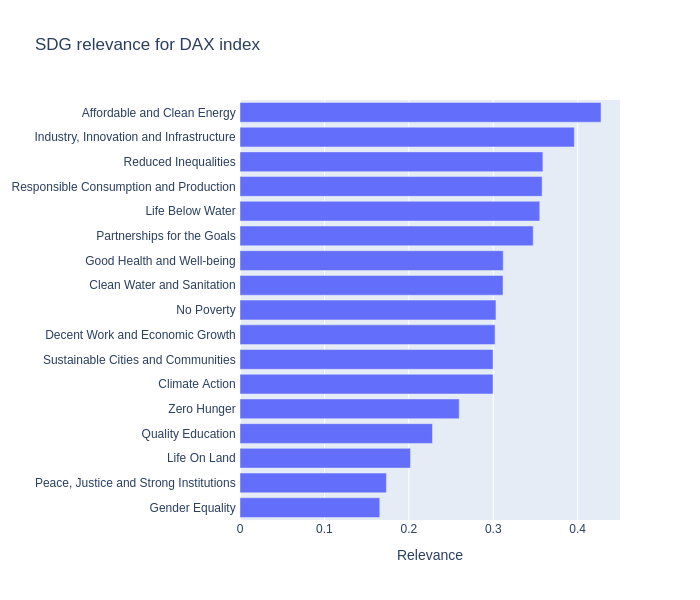

In [54]:
# Convert the plot to a static image for GitHub 
image_bytes = pio.to_image(fig, format='png', height = 600, width = 700)

# Display the image using IPython.display module in Jupyter Notebook
Image(image_bytes)

### Most relevant SDGs for a specific company, contrasting internal and external data

In this analysis, we focus on a specific company which is defined using the COMPANY variable. We look up the "internal" and "external" embeddings for this company, average them and measure their similarity with each of the SDGs.

In [18]:
# Function to create SDG dataframe for analysis
def create_sdg_df(companies):

  # Initiate empty lists for dictionaries
  company_dicts = []

  # Loop over company list
  for company in companies:

    # Assign current company
    COMPANY = company

    # Get internal embeddings
    internal_company_indices = esg_documents_df[(esg_documents_df.company == COMPANY) & (esg_documents_df.internal == 1)].index
    internal_company_embedding = np.mean(company_text_embeddings[internal_company_indices], axis=0)

    # Get external embeddings
    external_company_indices = esg_documents_df[(esg_documents_df.company == COMPANY) & (esg_documents_df.internal == 0)].index
    external_company_embedding = np.mean(company_text_embeddings[external_company_indices], axis=0)

    # Get external embeddings
    overall_company_indices = esg_documents_df[(esg_documents_df.company == COMPANY)].index
    overall_company_embedding = np.mean(company_text_embeddings[overall_company_indices], axis=0)

    # Get scores
    company_sdg_relevance_scores = [[cosine_similarity(internal_company_embedding, sdg_embedding), 
                                    cosine_similarity(external_company_embedding, sdg_embedding),
                                    cosine_similarity(overall_company_embedding, sdg_embedding)] for sdg_embedding in sdg_embeddings]
    company_sdg_relevance_df = pd.DataFrame.from_records(company_sdg_relevance_scores, index=sdg_df["name"], columns=["internal", "external", "overall"])
    
    # Reset index
    company_sdg_relevance_df.reset_index(inplace=True)

    # Create list of dictionaries
    data = []
    for _, row in company_sdg_relevance_df.iterrows():
        name = row['name']
        internal = row['internal']
        external = row['external']
        overall = row['overall']
        mean_int_ext = (internal + external) / 2  # Calculate the mean
        diff = (internal - external)

        dictionary = {'name': name, 'internal': internal, 'external': external, 'overall': overall, 'mean_internal_external': mean_int_ext, 'diff': diff}
        data.append(dictionary)

    # Create company SDG dictionary
    company_sdg_relevance_dict = {'company': COMPANY,
                                  'industry': esg_documents_df[esg_documents_df['company']==COMPANY]['industry'].values[0],
                                  'sdg_relevance': data}

    # Append company SDG dictionary to list of dictionaries
    company_dicts.append(company_sdg_relevance_dict)

  # Call function and create dataframe
  df = pd.DataFrame(company_dicts)

  return df

# Call function and create dataframe
company_sdg_relevance_df = create_sdg_df(companies=companies)

# Safe dataframe to csv
# company_sdg_relevance_df.to_csv('/content/drive/MyDrive/Colab_Notebooks/CLT_Project_HSLU_Stage3/sentence_embedded_data.csv', index=False, sep='|')

# Display header
company_sdg_relevance_df.head()

,company,industry,sdg_relevance
0,Adidas AG,Konsumgüter,"[{'name': 'No Poverty', 'internal': 0.27412089..."
1,Airbus SE,Transport / Verkehr,"[{'name': 'No Poverty', 'internal': 0.16286335..."
2,AkzoNobelNV,Chemie / Pharma,"[{'name': 'No Poverty', 'internal': 0.34493669..."
3,Allianz SE,Finanzsektor,"[{'name': 'No Poverty', 'internal': 0.32187211..."
4,BMW,Kraftfahrzeugindustrie,"[{'name': 'No Poverty', 'internal': 0.19657061..."


In [19]:
# Load company_sdg_relevance_df
#company_sdg_relevance_df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/CLT_Project_HSLU_Stage3/sentence_embedded_data.csv', delimiter='|')

company_sdg_relevance_df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks_FS23/CLT/Stage_4/sentence_embedded_data.csv', delimiter='|')

# Apply eval function to columns sdg_relevance
company_sdg_relevance_df['sdg_relevance'] = company_sdg_relevance_df['sdg_relevance'].apply(eval)

# Display header
company_sdg_relevance_df.head()

,company,industry,sdg_relevance
0,Adidas AG,Konsumgüter,"[{'name': 'No Poverty', 'internal': 0.27412092..."
1,Airbus SE,Transport / Verkehr,"[{'name': 'No Poverty', 'internal': 0.16286335..."
2,AkzoNobelNV,Chemie / Pharma,"[{'name': 'No Poverty', 'internal': 0.34493666..."
3,Allianz SE,Finanzsektor,"[{'name': 'No Poverty', 'internal': 0.32187214..."
4,BMW,Kraftfahrzeugindustrie,"[{'name': 'No Poverty', 'internal': 0.19657061..."


In [20]:
type(company_sdg_relevance_df['sdg_relevance'][0])

list

In [21]:
# Function to display company SDG data
def company_sdg(company):

  # Inspect SDG data for one company
  data = company_sdg_relevance_df.loc[company_sdg_relevance_df['company'] == company]['sdg_relevance']
  data_list = data.reset_index(drop=True).to_dict()

  # Create company dataframe
  df = pd.DataFrame(data_list[0])
  df = df.sort_values(by='internal', ascending=False)

  return df

# Select company
company = 'BMW'

# Create company data
company_df = company_sdg(company=company)

In [ ]:
# Display results
fig = go.Figure(data=[
    go.Bar(name='Internal', x=company_df["internal"], y=company_df['name'], orientation='h'),
    go.Bar(name='External', x=company_df["external"], y=company_df['name'], orientation='h')
])

fig.update_layout(barmode='group', height=800, width=1000, yaxis=dict(autorange="reversed"), title=f"SDG Relevance for {company}")
fig.update_xaxes(title="Relevance")
fig.show()

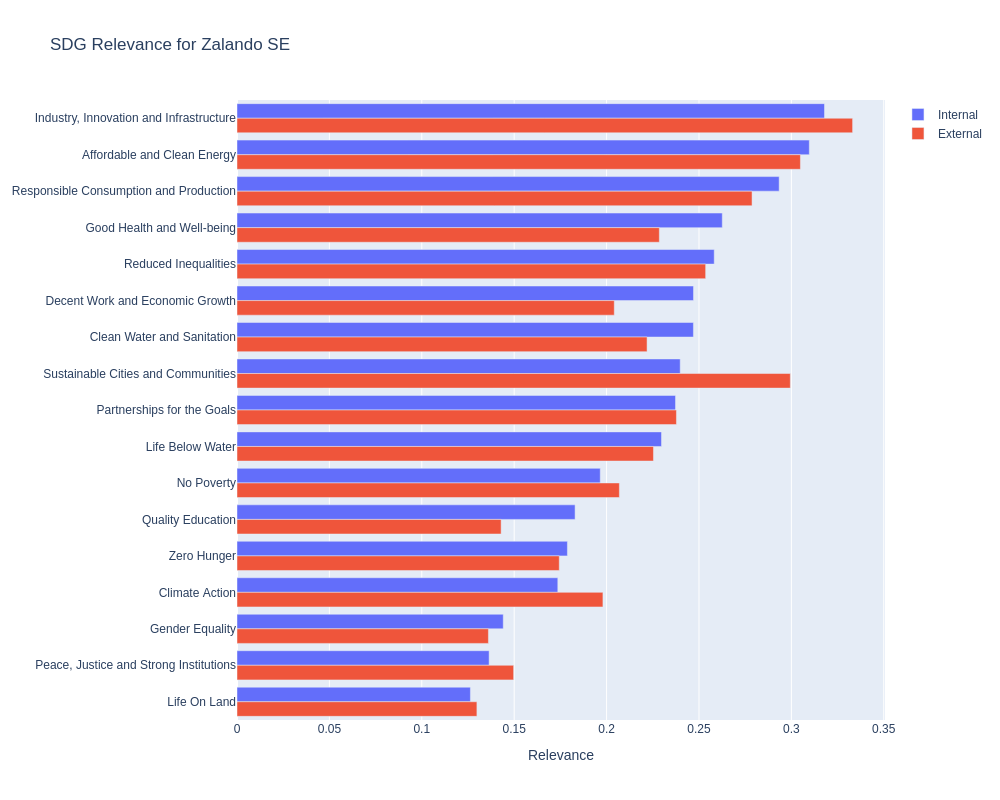

In [52]:
# Convert the plot to a static image for GitHub 
image_bytes = pio.to_image(fig, format='png', height = 800, width = 1000)

# Display the image using IPython.display module in Jupyter Notebook
Image(image_bytes)

Next steps to further explore the data:

- What are the internally most important SDGs for BMW?
- What are the most important SDGs for BMW when we take into account both the internal and the external data?
- What are the SDGs for BMW with the largest relevance gap between internal and external data?

In [23]:
# Internally most important SDG
# Get the top 3 rows based on the 'internal' column
top_3_internal = company_df.nlargest(3, 'internal')

# Print the name and internal value for each row
print(f"Top 3 internally most important SDG's for {company}:")
for index, row in top_3_internal.iterrows():
    print(f"Name: {row['name']}, Internal Value: {round(row['internal'], 3)}")

# Externally most important SDG
# Get the top 3 rows based on the 'external' column
print('\n' + f"Top 3 externally most important SDG's for {company}:")
top_3_external = company_df.nlargest(3, 'external')

# Print the name and external value for each row
for index, row in top_3_external.iterrows():
    print(f"Name: {row['name']}, Internal Value: {round(row['external'], 3)}")

# Overall most important SDG
# Get the top 3 rows based on the 'overall' column
print('\n' + f"Top 3 overall most important SDG's for {company}:")
top_3_overall = company_df.nlargest(3, 'overall')

# Print the name and overall value for each row
for index, row in top_3_overall.iterrows():
    print(f"Name: {row['name']}, Internal Value: {round(row['overall'], 3)}")

# SDG with largest relevance GAP between internal and external
# Calculate the absolute difference between internal and external values
company_df['abs_diff'] = company_df['internal'].sub(company_df['external']).abs()

# Get the top 3 rows based on the 'abs_diff' column
top_3_diff = company_df.nlargest(3, 'abs_diff')

# Print the name and absolute difference value for each row
print('\n' + f"Top 3 absolute differences between internal and external for {company}:")
for index, row in top_3_diff.iterrows():
    print(f"Name: {row['name']}, Absolute Difference: {round(row['abs_diff'], 3)}, Effective Difference: {round(row['diff'], 3)}")

Top 3 internally most important SDG's for BMW:
Name: Industry, Innovation and Infrastructure, Internal Value: 0.318
Name: Affordable and Clean Energy, Internal Value: 0.31
Name: Responsible Consumption and Production, Internal Value: 0.293

Top 3 externally most important SDG's for BMW:
Name: Industry, Innovation and Infrastructure, Internal Value: 0.333
Name: Affordable and Clean Energy, Internal Value: 0.305
Name: Sustainable Cities and Communities, Internal Value: 0.299

Top 3 overall most important SDG's for BMW:
Name: Industry, Innovation and Infrastructure, Internal Value: 0.333
Name: Affordable and Clean Energy, Internal Value: 0.305
Name: Sustainable Cities and Communities, Internal Value: 0.299

Top 3 absolute differences between internal and external for BMW:
Name: Sustainable Cities and Communities, Absolute Difference: 0.06, Effective Difference: -0.06
Name: Decent Work and Economic Growth, Absolute Difference: 0.043, Effective Difference: 0.043
Name: Quality Education, Abs

## 4. SDG Alignment by Industry: Financial Sector

This section provides an overview of SDG alignment for the financial sector.

In [24]:
# Function to display industry SDG data
def industry_sdg(industry):

  # Inspect SDG data for one company
  data = company_sdg_relevance_df.loc[company_sdg_relevance_df['industry'] == industry]['sdg_relevance']
  data_list = data.reset_index(drop=True).to_dict()

  # Create company dataframe
  df = pd.DataFrame(data_list[0])
  df = df.sort_values(by='internal', ascending=False)

  return df

# Select company
industry = 'Finanzsektor'

# Create company data
industry_df = industry_sdg(industry=industry)

In [ ]:
# Display results
fig = go.Figure(data=[
    go.Bar(name='Internal', x=industry_df["internal"], y=industry_df['name'], orientation='h'),
    go.Bar(name='External', x=industry_df["external"], y=industry_df['name'], orientation='h')
])

fig.update_layout(barmode='group', height=800, width=1000, yaxis=dict(autorange="reversed"), title=f"SDG Relevance for {industry}")
fig.update_xaxes(title="Relevance")
fig.show()

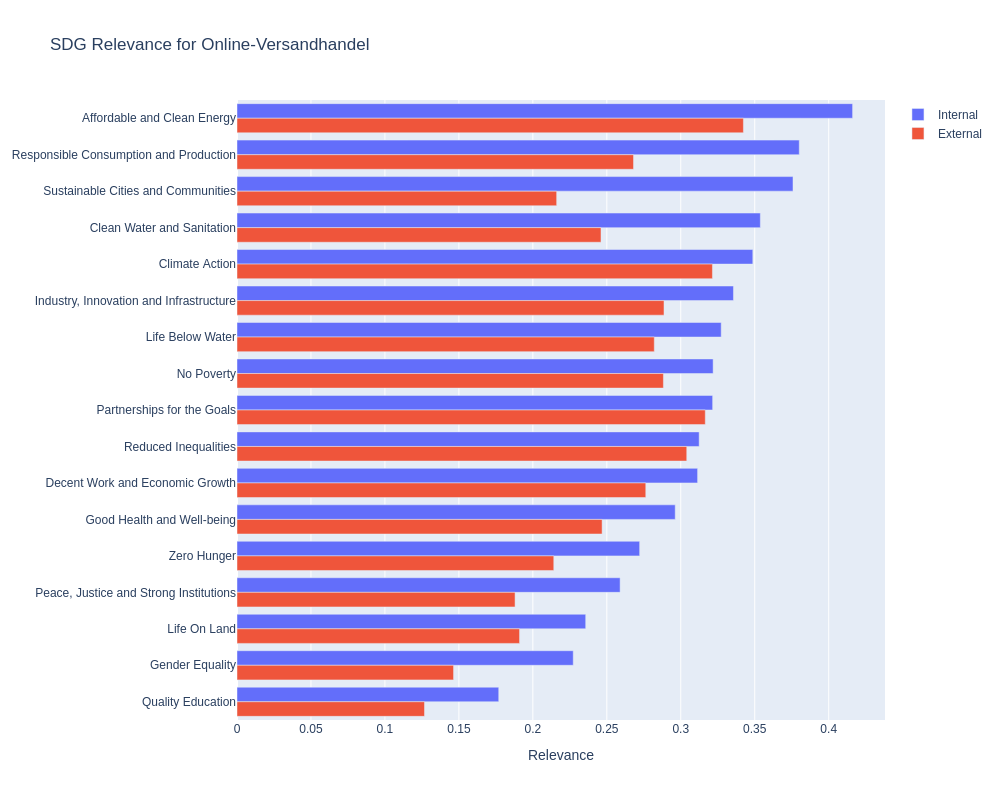

In [50]:
# Convert the plot to a static image for GitHub 
image_bytes = pio.to_image(fig, format='png', height = 800, width = 1000)

# Display the image using IPython.display module in Jupyter Notebook
Image(image_bytes)

In [26]:
# Internally most important SDG
# Get the top 3 rows based on the 'internal' column
top_3_internal = industry_df.nlargest(3, 'internal')

# Print the name and internal value for each row
print(f"Top 3 internally most important SDG's for {industry}:")
for index, row in top_3_internal.iterrows():
    print(f"Name: {row['name']}, Internal Value: {round(row['internal'], 3)}")

# Externally most important SDG
# Get the top 3 rows based on the 'external' column
print('\n' + f"Top 3 externally most important SDG's for {industry}:")
top_3_external = industry_df.nlargest(3, 'external')

# Print the name and external value for each row
for index, row in top_3_external.iterrows():
    print(f"Name: {row['name']}, Internal Value: {round(row['external'], 3)}")

# Overall most important SDG
# Get the top 3 rows based on the 'overall' column
print('\n' + f"Top 3 overall most important SDG's for {industry}:")
top_3_overall = industry_df.nlargest(3, 'overall')

# Print the name and overall value for each row
for index, row in top_3_overall.iterrows():
    print(f"Name: {row['name']}, Internal Value: {round(row['overall'], 3)}")

# SDG with largest relevance GAP between internal and external
# Calculate the absolute difference between internal and external values
industry_df['abs_diff'] = industry_df['internal'].sub(industry_df['external']).abs()

# Get the top 3 rows based on the 'abs_diff' column
top_3_diff = industry_df.nlargest(3, 'abs_diff')

# Print the name and absolute difference value for each row
print('\n' + f"Top 3 absolute differences between internal and external for {industry}:")
for index, row in top_3_diff.iterrows():
    print(f"Name: {row['name']}, Absolute Difference: {round(row['abs_diff'], 3)}, Effective Difference: {round(row['diff'], 3)}")

Top 3 internally most important SDG's for Finanzsektor:
Name: Affordable and Clean Energy, Internal Value: 0.416
Name: Responsible Consumption and Production, Internal Value: 0.38
Name: Sustainable Cities and Communities, Internal Value: 0.376

Top 3 externally most important SDG's for Finanzsektor:
Name: Affordable and Clean Energy, Internal Value: 0.342
Name: Climate Action, Internal Value: 0.321
Name: Partnerships for the Goals, Internal Value: 0.317

Top 3 overall most important SDG's for Finanzsektor:
Name: Affordable and Clean Energy, Internal Value: 0.345
Name: Climate Action, Internal Value: 0.323
Name: Partnerships for the Goals, Internal Value: 0.318

Top 3 absolute differences between internal and external for Finanzsektor:
Name: Sustainable Cities and Communities, Absolute Difference: 0.16, Effective Difference: 0.16
Name: Responsible Consumption and Production, Absolute Difference: 0.112, Effective Difference: 0.112
Name: Clean Water and Sanitation, Absolute Difference: 0.

### Heatmap of SDG relevance for all companies

In this analyses, we look at the alignment of all companies with the 17 SDGs, creating an overview over the DAX index.

In [27]:
company_embeddings = []
for company in companies:
    company_indices = esg_documents_df[esg_documents_df.company == company].index
    company_embedding = np.mean(company_text_embeddings[company_indices], axis=0)
    company_embeddings.append(company_embedding)
     

In [28]:
company_records = []

for company_embedding in company_embeddings:
    company_record = []
    for sdg_embedding in sdg_embeddings:
        company_record.append(cosine_similarity(company_embedding, sdg_embedding))
    company_records.append(company_record)

In [29]:
heatmap_array = np.array(company_records)
heatmap_array.shape

(36, 17)

In [30]:
# Unsorted overview
# fig = go.Figure(data=go.Heatmap(
#         z=heatmap_array,
#         x=sdg_df["name"].tolist(),
#         y=[company + " " for company in companies],
#         colorscale='Viridis'))

# fig.update_layout(height=1000)

# fig.show()

Next steps to further explore the data:

- What are the companies that are most aligned with the SDGs? (sort by sum of rows)
- Which SDGs are most relevant for the DAX index? (sort by sum of columns)

In [ ]:
# sort heatmap array (shape: (36,17)) by sum of row values descending
heatmap_array_sorted = heatmap_array[np.argsort(heatmap_array.sum(axis=1))]
# creat sorted list of company names according to heatmap_array_sorted
companies_sorted = [companies[i] for i in np.argsort(heatmap_array.sum(axis=1))]
# display heatmap_array_sorted as fig2
fig2 = go.Figure(data=go.Heatmap( z=heatmap_array_sorted, x=sdg_df["name"].tolist(), y=[company + " " for company in companies_sorted], colorscale='Viridis'))
fig2.update_layout(height=1000)
fig2.update_layout(title_text='Allignment of DAX companies with SDGs', title_x=0.5, title_font=dict(size=30))
fig2.show()

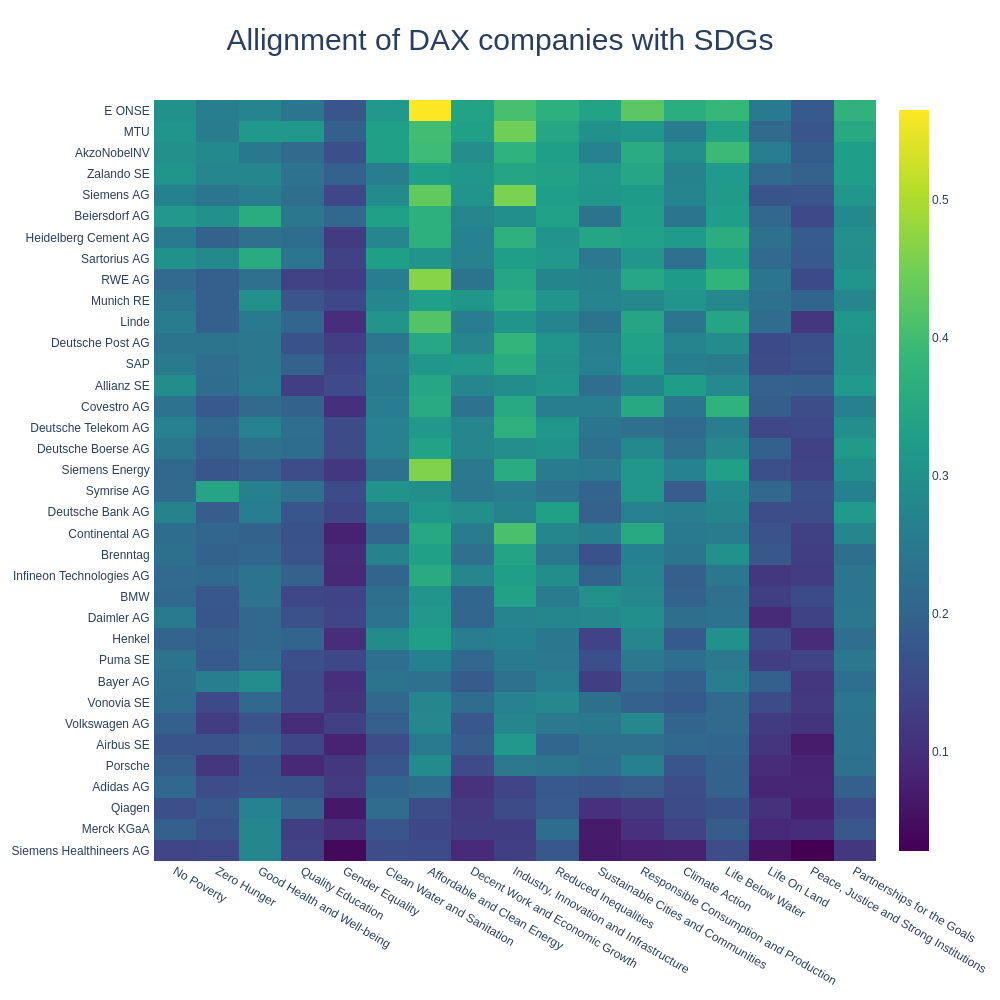

In [32]:
# Convert the plot to a static image for GitHub 
image_bytes = pio.to_image(fig2, format='png', height = 1000, width = 1000)

# Display the image using IPython.display module in Jupyter Notebook
Image(image_bytes)

The plot above show the overall importance of SDG goals for DAX companies, using the mean of the SDG embeddings over all documents. SDG alignment is defined as the similarity between the company-related texts and the SDG descriptions. In addition, the plot is sorted by the sum of each row, showing for example that the company E. ON has the highest overall sum of SDG alignment, especially in regard to the SDG 'Affordable and Clean Energy'. 


In [ ]:
# sort heatmap array (shape: (36,17)) by sum of column values descending
heatmap_array_sorted_columns = heatmap_array[:, np.argsort(heatmap_array.sum(axis=0))]
# creat sorted list of sdg names according to heatmap_array_sorted_columns
sdg_names_sorted = [sdg_df["name"].tolist()[i] for i in np.argsort(heatmap_array.sum(axis=0))]
# display heatmap_array_sorted_columns as fig3
fig3 = go.Figure(data=go.Heatmap( z=heatmap_array_sorted_columns, x=sdg_names_sorted, y=[company + " " for company in companies], colorscale='Viridis'))
fig3.update_layout(height=1000)
fig3.update_layout(title_text='Relevance of SDGs for DAX companies', title_x=0.5, title_font=dict(size=30))
fig3.show()

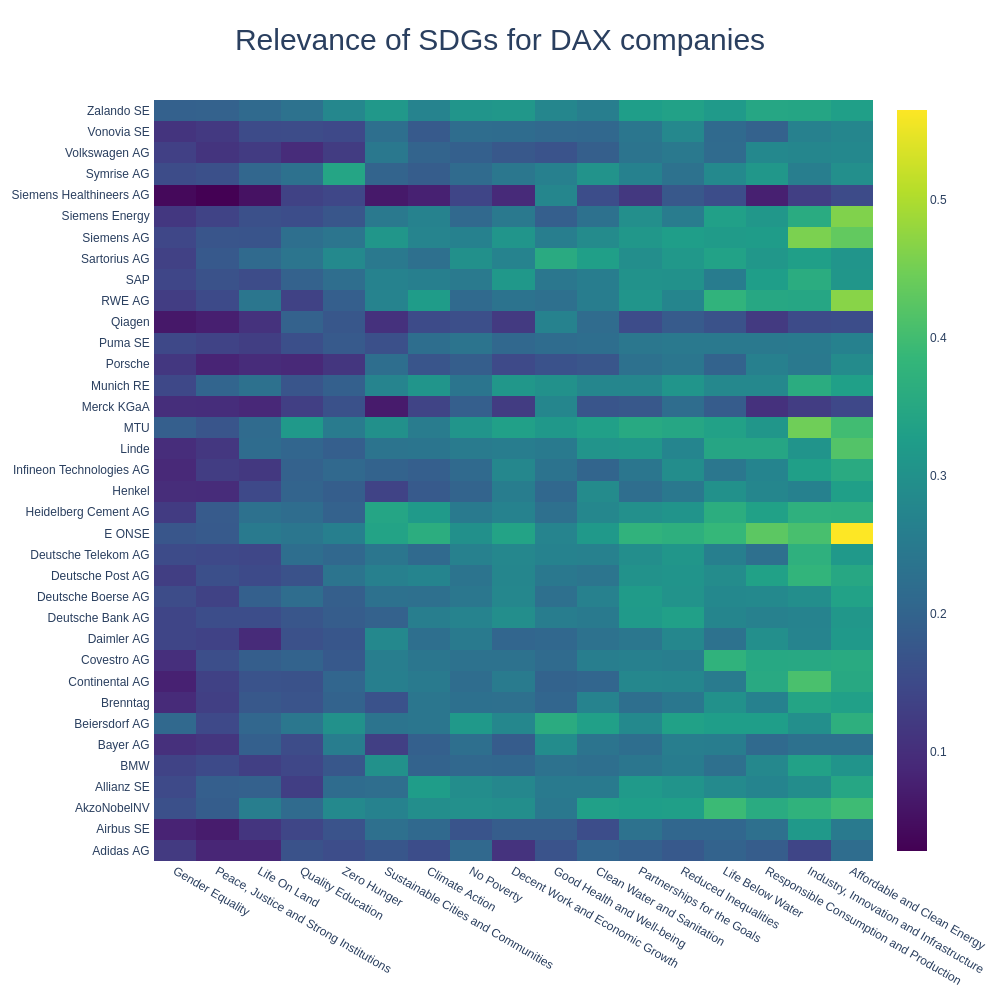

In [34]:
# Convert the plot to a static image for GitHub 
image_bytes = pio.to_image(fig3, format='png', height = 1000, width = 1000)

# Display the image using IPython.display module in Jupyter Notebook
Image(image_bytes)

When sorting the overall SDG alligment by the sum of each column, the most important SDGs for DAX comapnies can be identified on the right side of the plot. The three most important SDGs are 'Affordable and Clean Energy', 'Industry, Innovation and Infrastructure' and 'Responsible Consumption and Production'. 


In [ ]:
# Create a heatmap of company_sdg_relevance_df['sdg_relevance'] using 'diff' as values (internal - external)
diff_values_per_row = [
    [item['diff'] for item in sublist]
    for sublist in company_sdg_relevance_df['sdg_relevance']
]

heatmap_array_diff = np.array(diff_values_per_row)

# Calculate the row sums
row_sums = heatmap_array_diff.sum(axis=1)

# Sort heatmap_array_diff and row_sums in descending order
sorted_indices = np.argsort(row_sums)  #[::-1]
heatmap_array_diff_sorted = heatmap_array_diff[sorted_indices]
row_sums_sorted = row_sums[sorted_indices]

# Create a sorted list of company names according to heatmap_array_diff_sorted
companies_sorted = [companies[i] for i in sorted_indices]

# Display heatmap_array_diff_sorted as fig4
fig4 = go.Figure(data=go.Heatmap(
    z=heatmap_array_diff_sorted,
    x=sdg_df["name"].tolist(),
    y=[company + " " for company in companies_sorted],
    colorscale='RdYlGn_r',  # Use 'RdYlGn_r' for the inverted colorscale
    zmid=0  # Set the midpoint at 0
))
fig4.update_layout(height=1000)
fig4.update_layout(title_text='Differences of Internal minus External SDG values', title_x=0.5, title_font=dict(size=30))
fig4.show()


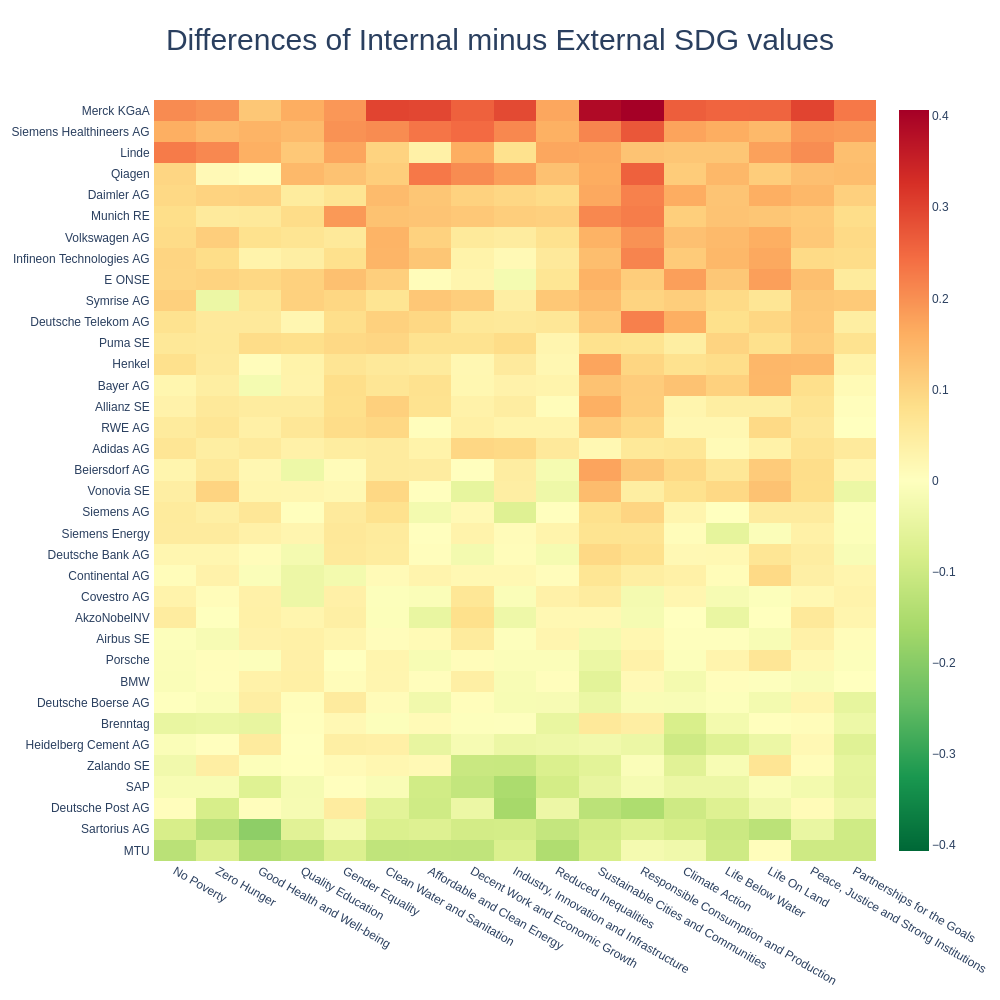

In [36]:
# Convert the plot to a static image for GitHub 
image_bytes = pio.to_image(fig4, format='png', height = 1000, width = 1000)

# Display the image using IPython.display module in Jupyter Notebook
Image(image_bytes)

When comparing internal and external SDG embeddings using the difference of the internal minus the external SDG score, interesting patterns appear. The darker a SDG is colored in red, the more important is it according to the company, but less mentioned by external sources. Fields colored yellow indicate rather matching internal and external scores. For example, the companies Vonovia SE and Beiersdorf AG report the smallest differences. At the bottom of the plot, colored in increasing green, companies are listed for which the external sources show stronger similarity with the SDG descriptions as the internal documents.

##5. SDG Relevance and Differences by Industries

This section examines the relevance of the SDGs goals for the DAX companies by their industry, as well as the differences of the internal and external embeddings.

In [37]:
# Extract unique industries
industries = company_sdg_relevance_df['industry'].unique().tolist()

In [38]:
industry_embeddings = []
for industry in industries:
    industry_indices = esg_documents_df[esg_documents_df.industry == industry].index
    industry_embedding = np.mean(company_text_embeddings[industry_indices], axis=0)
    industry_embeddings.append(industry_embedding)

In [39]:
industry_records = []

for industry_embedding in industry_embeddings:
    industry_record = []
    for sdg_embedding in sdg_embeddings:
        industry_record.append(cosine_similarity(industry_embedding, sdg_embedding))
    industry_records.append(industry_record)

In [40]:
heatmap_array = np.array(industry_records)
heatmap_array.shape

(15, 17)

In [ ]:
fig = go.Figure(data=go.Heatmap(
        z=heatmap_array,
        x=sdg_df["name"].tolist(),
        y=[industry + " " for industry in industries],
        colorscale='Viridis'))

fig.update_layout(height=1000)
fig.update_layout(title_text='Relevance of SDGs for DAX companies', title_x=0.5, title_font=dict(size=30))

fig.show() # interactive plotly graph

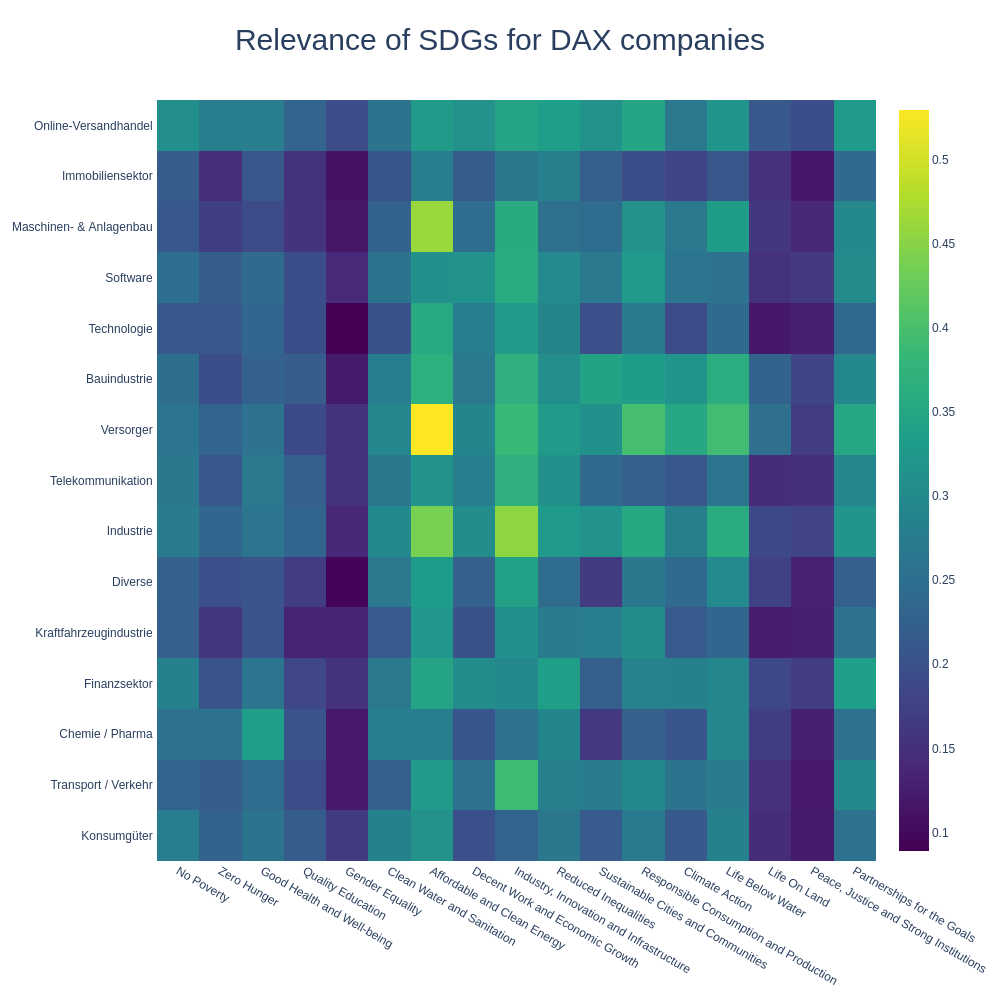

In [42]:
# Convert the plot to a static image for GitHub 
image_bytes = pio.to_image(fig, format='png', height = 1000, width = 1000)

# Display the image using IPython.display module in Jupyter Notebook
Image(image_bytes)

The plot above shows the importance of the different SDG goals per industry, the stronger the green or even yellow share of the colour of a field, the more important an SDG is. For example, the previously identified most important SDG 'Affordable and Clean Energy', seems to be particularly critical for utility providers ('Versorger'), industry ('Industrie'), as well as machinery and plant engineering ('Maschinen & Anlagenbau'). 

In [ ]:
# Differences per industry
# Extract the mean values per industry considering the 'industry' column in company_sdg_relevance_df and the unique industries in industries
mean_values_per_industry = [ np.mean(np.array(diff_values_per_row)[company_sdg_relevance_df['industry'] == industry], axis=0) for industry in industries ]

# sort mean_values_per_industry by sum of row values descending
mean_values_per_industry_sorted = np.array(mean_values_per_industry)[np.argsort(np.array(mean_values_per_industry).sum(axis=1))][::-1]
# creat sorted list of industry names according to mean_values_per_industry_sorted
industries_sorted = [industries[i] for i in np.argsort(np.array(mean_values_per_industry).sum(axis=1))][::-1]

# create a heatmap with mean_values_per_industry as values and industries as y-axis, x-axis is sdg_df["name"].tolist()
fig5 = go.Figure(data=go.Heatmap( z=mean_values_per_industry_sorted, x=sdg_df["name"].tolist(), y=[industry + " " for industry in industries_sorted], colorscale='RdYlGn_r', zmid=0))
fig5.update_layout(height=1000)
fig5.update_layout(title_text='Differences of Internal minus External SDG values per Industry', title_x=0.5, title_font=dict(size=30))
fig5.show()


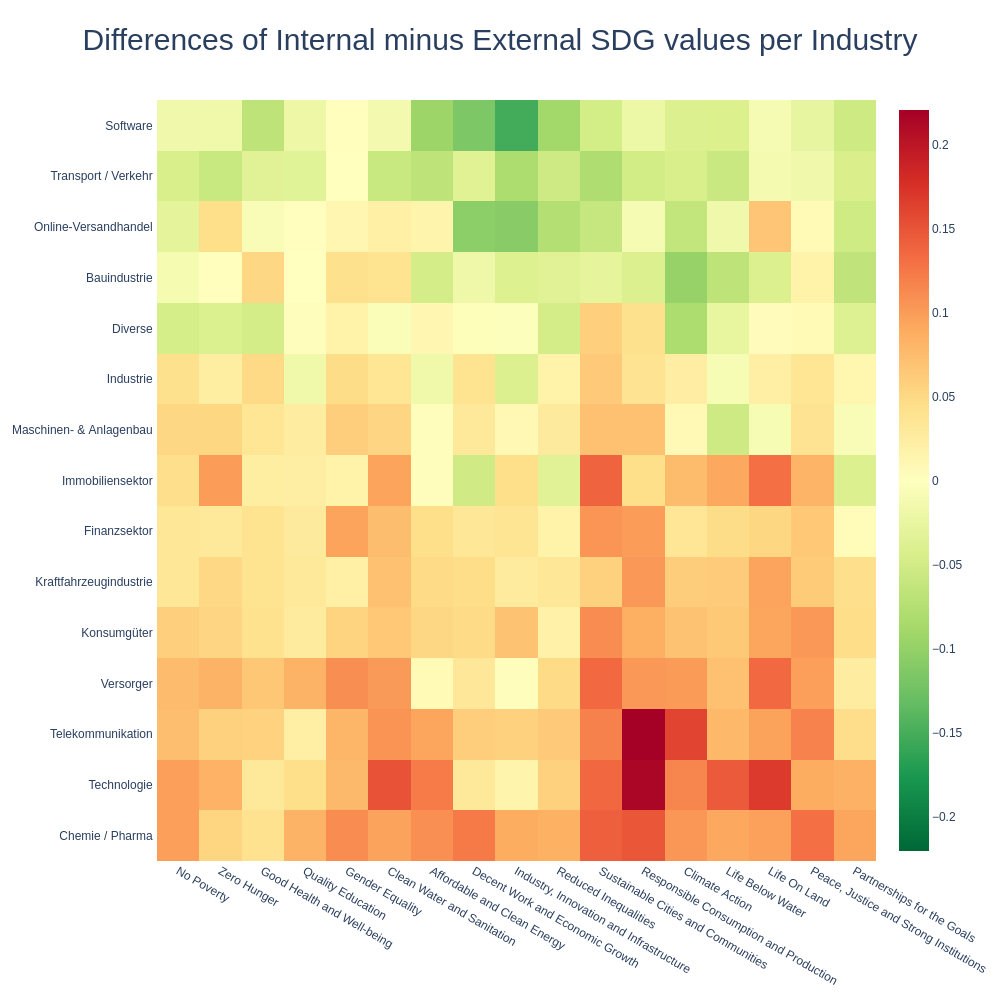

In [48]:
# Convert the plot to a static image for GitHub 
image_bytes = pio.to_image(fig5, format='png', height = 1000, width = 1000)

# Display the image using IPython.display module in Jupyter Notebook
Image(image_bytes)

When analyzing the differences the iternal and external SDG scores per industry, additional patterns can be observed. As the plot above is sorted by the sum of each row, the industries at the bottom of the plot show the largest negative discrepancy, colored in intensifying red. A negative discrepancy is assumed if the internal values are higher than the externales values. Especially the telecommunication-, technology-('Technologie'), and chemistry/pharma- ('Chemie/Pharma') sector show the largest negative inconsistency between internal and external company-related texts in regard to the SDG descriptions. 